In [1]:
# %load project_as_py.py
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

#from PAT_forward import PAT_forward

In [2]:
# Setup function space
nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)

In [3]:
#PAT forward solver for use with MUQ
class PAT_forward(mm.PyModPiece):
    
    def __init__(self, time_final, numSteps, c, V):
        """ 
        INPUTS:
        - time_final = final time
        - numSteps = number of time steps
        - c = speed of sound
        """
        mm.PyModPiece.__init__(self, [V.dim()],[V.dim()])
                  
        self.T_f = time_final
        self.numSteps = numSteps
        self.dt = self.T_f / self.numSteps
        self.c = c
        self.V = V
        
        self.p_trial = dl.TrialFunction(self.V)
        self.v = dl.TestFunction(self.V)
            
    def EvaluateImpl(self, inputs):
        """
        INPUTS:
        - inputs = parameter of interest as a numpy array
        
        OUTPUT:
        - solution of PAT forward problem as numpy array
        """
        m = dl.Function(self.V)
        m.vector().set_local(inputs[0])
        
        p_n = dl.Function(self.V)
        p_nm1 = dl.Function(self.V)
        p_n.assign(m)
        p_nm1.assign(m)
        p_trial = self.p_trial
        v = self.v
        
        F = (self.c**2)*(self.dt**2)*dl.inner(dl.grad(p_trial), dl.grad(v))*dl.dx - 2.*p_n*v*dl.dx + p_trial*v*dl.dx + p_nm1*v*dl.dx 
        a, L = dl.lhs(F), dl.rhs(F)
        
        # Time-stepping
        p = dl.Function(self.V)
        t = 0
        for n in range(self.numSteps):
            # Update current timtime
            t += self.dt

            # Compute solution
            dl.solve(a == L, p)

            # Update previous solution
            p_nm1.assign(p_n)
            p_n.assign(p)

        out = p.vector().get_local()
        
        self.outputs = [out]

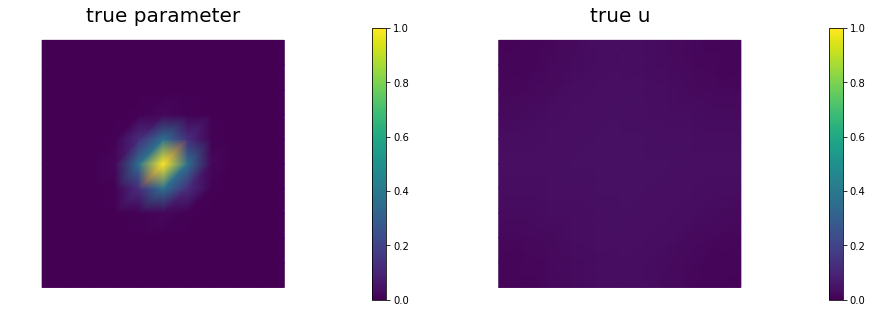

In [5]:
# Compute the synthetic data        
time_final = 800e-6
numSteps = 20
c = 1500
#numObs = 121
test = PAT_forward(time_final, numSteps, c, V)
#test = PAT_forward(time_final, numSteps, c, V, numObs)
m = dl.interpolate(dl.Expression('exp((-(x[0]-.5)*(x[0]-.5) -(x[1]-.5)*(x[1]-.5))/0.01)', degree=3), V)
#m = dl.interpolate(dl.Expression('( pow( x[0] - 0.5 , 2 ) + pow( x[1] - 0.5 , 2 ) < pow( 0.1 , 2 ))', degree = 3),V)
obsData = test.Evaluate([m.vector().get_local()])   

# # plot true parameter and observed data
data = dl.Function(V)
data.vector().set_local(obsData[0])
nb.multi1_plot( [ m , data ] , ["true parameter", "true u"], same_colorbar=True)
plt.show()

# s = 1
# plt.plot(obsData[0][s::numObs])
# plt.show()

fwdSolver = PAT_forward(time_final, numSteps, c, V)
#fwdSolver = PAT_forward(time_final, numSteps, c, V, numObs)

In [6]:
# Setup the Prior
xDim=2;
yDim=1;

# Variance and [#] in mean is average value of true parameter

var = 0.01     # Marginal Variance
length = 0.1    # Lengthscale of the kernel
nu = 5.0/2.0  # Smoothness parameter

kern = ma.MaternKernel(xDim, var, length, nu)
mean = ma.LinearMean(np.zeros((1,xDim)), [0.25])

logPrior = ma.GaussianProcess(mean, kern).Discretize(mesh.coordinates().T).AsDensity()

In [9]:
# Setup the Likelihood  
noiseVar = 1e-4
noiseCov = noiseVar*np.ones((obsData[0].shape[0])) #np.eye(obsData[0].shape[0])
likelihood = mm.Gaussian(obsData[0], noiseCov).AsDensity()

# MUQ stuff needed for posterior
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())

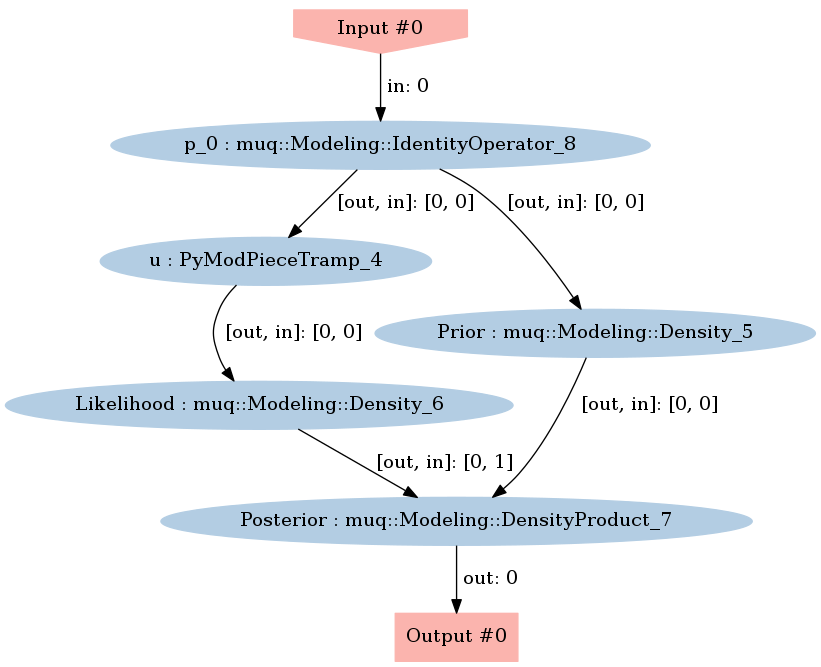

In [10]:
# Setup a graph of the work
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

# Create the graph 
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 



In [11]:
# Look at MCMC statistics
def look_at_stats(samps):
    ess = samps.ESS()
    print('Average Effective Sample Size = \n', np.average(ess))

    sampMean = samps.Mean()
    mean = dl.Function(V)
    mean.vector().set_local(sampMean)
    nb.plot(mean)
    plt.show()

    sampCov = samps.Covariance()
    #print('\nSample Covariance = \n', sampCov)

    mcErr = np.sqrt( samps.Variance() / ess)
    #print('\nEstimated MC error in mean = \n', mcErr)

    sampMat = samps.AsMatrix()

    plt.plot(sampMat.T)
    plt.show()

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 26%
  20% Complete
    Block 0:
      Acceptance Rate = 13%
  30% Complete
    Block 0:
      Acceptance Rate = 8.7%
  40% Complete
    Block 0:
      Acceptance Rate = 6.5%
  50% Complete
    Block 0:
      Acceptance Rate = 5.2%
  60% Complete
    Block 0:
      Acceptance Rate = 4.4%
  70% Complete
    Block 0:
      Acceptance Rate = 3.7%
  80% Complete
    Block 0:
      Acceptance Rate = 3.3%
  90% Complete
    Block 0:
      Acceptance Rate = 2.9%
  100% Complete
    Block 0:
      Acceptance Rate = 2.6%
Completed in 819.119 seconds.
Average Effective Sample Size = 
 35.1507443112


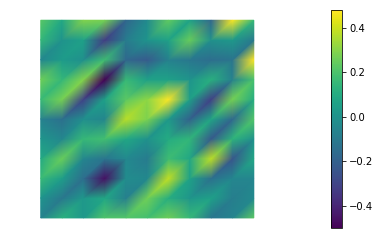

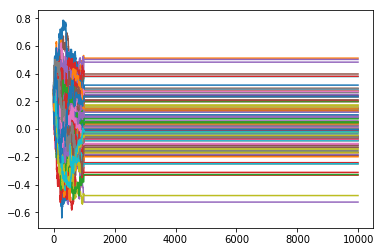

In [14]:
# Setup AM sampler
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 0.0005 #think highly correlated = valley 
proposalOptions['AdaptSteps'] = 500
proposalOptions['AdaptStart'] = 500
proposalOptions['AdaptScale'] = 0.0000004#2.0 #multiple average cov from samples

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 10000
options['ThinIncrement'] = 1
options['BurnIn'] = 10
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

# Choose a staring point and sample
startPt = 0.25 * np.ones((V.dim()))
samps = mcmc.Run(startPt)
look_at_stats(samps)

In [ ]:
# 0.05 bad
# 0.5 bad

# Everywhere
# 0.5, adst =100, adstep = 100 adsc = 0.1, samps = 1000 => bad when adapt starts
# 0.5, adst =500, adstep = 500 , adsc = 0.1, samps = 10000 => bad when adapt starts
# 0.5, adst =500, adstep = 500 , adsc = 0.01, samps = 1000 => bad when adapt starts
# 0.5, adst =500, adstep = 500 , adsc = 0.0001, samps = 1000 => bad when adapt starts
# 0.5, adst =500, adstep = 500 , adsc = 0.0, samps = 1000 => bad after 50 steps
# 0.05, adst =500, adstep = 500 , adsc = 2.0, samps = 1000 => bad after 50 steps
# 0.0005, adst =500, adstep = 500 , adsc = 2.0, samps = 1000 => better, getting neg values